**Or Segal**


# Introduction

A phylogenetic tree describes the evolutionary relationship between species in a tree form. Based on the species' physical characteristics and genetic similarity (or each one separately), the tree demonstrates the ancestor-dependent relationships. While it is possible to build phylogenetic trees based solely on a logical inference of the morphological attributes, the more recent field of molecular phylogenetics uses DNA or amino acid sequences for a more accurate process of reconstructing the tree. 

There are several common ways for building phylogenetic trees which are divided to two main categories: distance based approaches such as cluster analysis techniques and character based approaches such as maximum parsimony and maximum likelihood. In this paper, I will focus on the former category and implement a common clustering algorithm - UPGMA (Unweighted Pair Group Method with Arithmetic Mean).

# UPGMA

The UPMGA Algoritm is an agglomerative hirarchical clustering algorithm. It is using a distance matrix that in our case uses an edit distance between strings. In its operation, it combines a defined number of closest elements in a cluster and calculated the distance between the cluster and the rest of the elements based on a mean of the defined distance measurement. Caculation of the average distance between clusters can be achived using this formula:

\begin{equation*}
D(C_{k}, (C_{i} \cup C_{j})) = \frac{|C_{i}|}{|C_{i}|+|C_{j}|}D(C_{k}, C_{i}) + \frac{|C_{j}|}{|C_{i}|+|C_{j}|}D(C_{k}, C_{j})
\end{equation*}

Gronau and Moran (2007) provide an optimal implemetation of UPGMA using the following reduction formula:

\begin{equation*}
D(C, C') = \frac{1}{|C||C'|} \sum_{i \in C, j \in C'} D(i,j)
\end{equation*}


# Implementation

To work with phylogenetic trees in Python, I used a library called HackingTrees that is a resource in a course in Phylogenetic Methods and Theory at the University of Michigan taught by Stephen Smith (2014a/b). 

The DNA strings for the example were taken from the Basic Local Alignment Search Tool (BLAST). The strings I used are of different species of the Influenza virus (the flu) which were initially used in NS112 course at Minerva. Each string in the example has a length of $1300-1500$ nucleotides. 


To start the analysis, we load the strings from the fasta file which was produced and aligned by MEGA7. The strings are converted into a node class that was adjusted from the one in the HackingTrees library. We then print a distance table.


In [13]:
import os
from tabulate import tabulate
from hackingtrees.sequences import seq_reader
from hackingtrees.trees.tree_printer import *
import time
import sys
import pickle
import operator
import copy


class Node:
    def __init__(self):
        self.label = ""
        self.length = 0.0
        self.time_length = 0.0
        self.parent = None
        self.children = []
        self.data = {}
        self.istip = False
        self.height = 0
        self.id = None

    def add_child(self,child):
        # make sure that the child is not already in there
        assert child not in self.children
        self.children.append(child)
        child.parent = self

    def remove_child(self,child):
        #make sure that the child is in there
        assert child in self.children
        self.children.remove(child)
        child.parent = None

    def leaves(self,v=None):
        if v == None:
            v = []
        if len(self.children) == 0:
            v.append(self)
        else:
            for child in self.children:
                child.leaves(v)
        return v

    def leaves_fancy(self):
        return [n for n in self.iternodes() if n.istip ]

    def lvsnms(self):
        return [n.label for n in self.iternodes() if n.istip ]

    def iternodes(self,order="preorder"):
        if order.lower() == "preorder":
            yield self
        for child in self.children:
            for d in child.iternodes(order):
                yield d
        if order.lower() == "postorder":
            yield self

    def prune(self):
        p = self.parent
        if p != None:
            p.remove_child(self)
        return p

    def get_newick_repr(self,showbl=False):
        ret = ""
        for i in range(len(self.children)):
            if i == 0:
                ret += "("
            ret += self.children[i].get_newick_repr(showbl)
            if i == len(self.children)-1:
                ret += ")"
            else:
                ret += ","
        if self.label != None:
            ret += self.label
        if showbl == True:
            ret += ":" + str(self.length)
        return ret

    def set_height(self):
        if len(self.children) == 0:
            self.height = 0
        else:
            tnode = self
            h = 0
            while len(tnode.children) > 0:
                if tnode.children[1].length < tnode.children[0].length:
                    tnode = tnode.children[1]
                else:
                    tnode = tnode.children[0]
                h += tnode.length
            self.height = h



def readStrings(filename):
    # Using the hackingtrees function for reading fasta files, import the strings.
    # Shorten the string names.
    seqs = seq_reader.read_fasta_file(filename)
    for i in seqs:
        strtInd = i.name.index('(')
        stringName = i.name[strtInd+3:]
        endInd = stringName.index('(')
        stringName = stringName[:endInd]
        i.name = stringName
    return seqs


def seqsToNodes(seqs):
    # Convert 
    
    allNodes = []
    tempID = 0
    for seq in seqs:
        tempNode = Node()
        tempNode.label = seq.name
        tempNode.data['seq'] = seq.seq
        tempNode.data['seqNoAlign'] = seq.seq.translate(None, '-')
        tempNode.data['NN'] = None
        tempNode.data['distToNN'] = None
        tempNode.id = tempID
        tempNode.istip = True
        tempID += 1
        allNodes.append(tempNode)
    return allNodes


def EditDistance(A, B):
    m = len(A)
    n = len(B)
    C = [[0] * (n+1) for _ in range(m+1)]

    # Distance of string to the other when it's empty
    for i in xrange(m+1):
        C[i][0] = i
    for j in xrange(n+1):
        C[0][j] = j

    for j in xrange(1, n+1):
        for i in xrange(1, m+1):
            if A[i-1] == B[j-1]:
                C[i][j] = C[i-1][j-1]
            else:
                deletion = C[i-1][j] + 1
                insertion = C[i][j-1] + 1
                substitution = C[i-1][j-1] + 1
                C[i][j] = min(deletion, insertion, substitution)
    return C[m][n]

def distanceTableToPrint(strings):
    Nstrings = len(strings)
    DTable = [[0] * (Nstrings) for _ in range(Nstrings)]
    for i in xrange(Nstrings):
        for j in xrange(i+1, Nstrings):
            DTable[i][j] = DTable[j][i] = EditDistance(strings[i], strings[j])
    return DTable

def StringsTableAnalysis(STable, strings, NHeader = None):
    Nstrings = len(strings)
    if NHeader == None:
        NHeader = range(Nstrings)
    print tabulate(STable, showindex='always', headers=NHeader, floatfmt=".3f")
    
def storeTable(nodes, filename, tableFunc):
    # Store the distance table to file. Building the table is the
    # most costly function so saving it saves time.

    STable = tableFunc(nodes)
    with open(filename, 'wb') as fp:
        pickle.dump(STable, fp)


def openTable(filename):
    with open(filename, 'rb') as fp:
        Table = pickle.load(fp)
    return Table
    

    
# Read strings from file
seqs = readStrings("FluGeneSeq-ClustalWAlligned10.fas")

# Convert strings to nodes
nodes = seqsToNodes(seqs)

# Print a distance table
strLst = []
for node in nodes:
    strLst.append(node.data['seqNoAlign'])

    
# storeTable(strLst, 'DTableToPrint.txt', distanceTableToPrint)
DTableToPrint = openTable('DTableToPrint.txt')
StringsTableAnalysis(DTableToPrint, strLst)


      0    1    2    3    4    5    6    7    8    9
--  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---
 0    0    9  160   58    9    5    5    5    5    7
 1    9    0  156   54    0    6    6    6    6    5
 2  160  156    0  103  156  157  157  157  157  156
 3   58   54  103    0   54   55   55   55   55   54
 4    9    0  156   54    0    6    6    6    6    5
 5    5    6  157   55    6    0    0    0    0    5
 6    5    6  157   55    6    0    0    0    0    5
 7    5    6  157   55    6    0    0    0    0    5
 8    5    6  157   55    6    0    0    0    0    5
 9    7    5  156   54    5    5    5    5    5    0


After having a visual represntation of the table, we construct a second table that will support the UPGMA algorithm. The algorithm is a dynamic one, however, the clustering change the values of the distances as the algorithm runs. In order to support that, the UPGMA uses a dictionary of dictionaries as its memory.

In [8]:

def distanceTable(nodes):
    # Build a distance table based on the edit distances. The table is built as a dictionary of dictionaries
    # (instead of a list of lists) in order to be able to edit it later and change the names of the nodes

    DTable = {}
    for node1 in nodes:
        DTable[node1.id] = {}
        for node2 in nodes:
            if node1 != node2:
                DTable[node1.id][node2.id] = 0
    keepTrack = []
    for node1 in nodes:
        keepTrack.append(node1.id)
        for node2 in nodes:
            if node2.id not in keepTrack:
                DTable[node1.id][node2.id] = DTable[node2.id][node1.id] = EditDistance(node1.data['seqNoAlign'],
                                                                                       node2.data['seqNoAlign'])
    return DTable



def updateNN(clusters, DTable):
    # Goes over all nodes and searches for the closest node or cluster of nodes (which is represented
    # as a node with children).

    for node in clusters:
        node.data['NN'] = None
        node.data['distToNN'] = None
        tempDist = float('inf')
        NNID = 0
        for key in DTable[node.id]:
            if DTable[node.id][key] < tempDist:
                tempDist = DTable[node.id][key]
                NNID = key
        node.data['NN'] = [x for x in clusters if x.id == NNID][0]
        node.data['distToNN'] = tempDist


def getClosestPair(clusters):
    minDist = float('inf')
    for node in clusters:
        if node.data['distToNN'] < minDist:
            minDist = node.data['distToNN']
            c1 = node
            c2 = node.data['NN']
            assert c2 is not None
            assert c2 is not c1
    return (c1, c2)


def clusterDistance(newC, c2, originalDTable):
    newClen = len(newC.data['nodesInBranch'])
    if len(c2.children) == 0:
        c2len = 1
    else:
        c2len = len(c2.data['nodesInBranch'])

    dist = 0
    for i in [n for n in newC.iternodes() if n.istip]:
        if c2len == 1:
            dist += originalDTable[i.id][c2.id]
        else:
            for j in [n for n in c2.iternodes() if n.istip]:
                dist += originalDTable[i.id][j.id]
    dist = dist/(newClen * c2len)
    return dist


def createOTU(c1, c2, DTable, originalDTable, clusters):
    # remove the two clusters that we will combine
    clusters.remove(c1)
    clusters.remove(c2)

    # create a new middle node
    newCluster = Node()
    newCluster.label = ("(" + str(c1.id) + ", " + str(c2.id) + ")")
    newCluster.data['NN'] = None
    newCluster.data['distToNN'] = None
    if len(clusters) != 0:
        newCluster.id = max(node.id for node in clusters) + 1
    newCluster.add_child(c1)
    newCluster.add_child(c2)
    newCluster.data['nodesInBranch'] = [n.id for n in newCluster.iternodes() if n.istip]

    clusters.append(newCluster)

    # Update the distance table
    ncDist = {}                     # dictionary of distances from the new cluster to append later
    for key in DTable:
        if (key != c1.id) and (key != c2.id):
            Ncomp = [x for x in clusters if x.id == key][0]
            ncDist[key] = clusterDistance(newCluster, Ncomp, originalDTable)

    DTable.pop(c1.id)
    DTable.pop(c2.id)
    for key in DTable:
        DTable[key].pop(c1.id)
        DTable[key].pop(c2.id)
        DTable[key][newCluster.id] = ncDist[key]
    DTable[newCluster.id] = ncDist


def UPGMA(clusters, originalDTable):
    DTable = copy.deepcopy(originalDTable)   # The distance table copy that we actually
                                             # manipulate as the algorithm runs

    for i in xrange(len(clusters) - 1):
        updateNN(clusters, DTable)
        c1, c2 = getClosestPair(clusters)
        createOTU(c1, c2, DTable, originalDTable, clusters)

    return clusters[0]

# storeTable(nodes, 'DTable.txt', distanceTable)
DTable = openTable('DTable.txt')

tree = UPGMA(nodes, DTable)
print tree2ascii(tree, scaled=0, show_internal_labels=0)

------------------------+ Piura/FLU3646/2006     
:                                                
:   --------------------+ Tumbes/AST0136/2006    
+   :                                            
:   :       ------------+ Peru/3355/2006         
:   :       :                                    
----+   ----+       ----+ BRISBANE/35/2006       
    :   :   :   ----+                            
    :   :   :   :   ----+ AUCKLAND/78/2006       
    :   :   ----+                                
    ----+       :   ----+ NORWAY/622/2006        
        :       ----+                            
        :           ----+ WAIKATO/49/2006        
        :                                        
        :     ----------+ MEXICO/2519/2006       
        ------+                                  
              :     ----+ Argentina/3509/2006    
              ------+                            
                    ----+ Argentina/AG-3509/2006 


The algoritm preformed well compared to common tree reconstruction algoritms such as MEGA7. The tree that came out of the MEGA software was slightly different, however even within different methods in the software, different outcomes emerge. See the MEGA tree below:

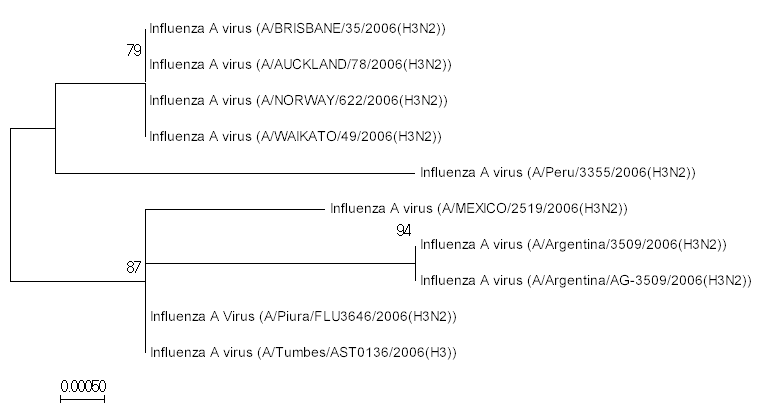

In [12]:
from IPython.display import Image
Image("TreeFinal.png")

# Algorithm Analysis

The most costly part of the algoritm is the construction of the original distance matrix which is $O(m^2)$ (m is the number of characters in a string) for each calculation of the edit distance times $O(n^2)$ which is the number of strings. The rest are much cheaper operations. That leads us to a final complexity of $O(n^2 \times m^2)$.


# Further Development

There are many ways to further develop the algoritm, some of them were discussed in the introduction. Another alternative is a genetic algoritm that will iterate over mutations and recombinations of an original tree and choose the one with the best scores. 


# References

Koichiro Tamura, Glen Stecher, Daniel Peterson, Alan Filipski, and Sudhir Kumar (2013) MEGA6: Molecular Evolutionary Genetics Analysis version 6.0. Molecular Biology and Evolution:30 2725-2729.

Holder, M. (2013). Phylogenetic inference. In J. B. Losos (Ed.). The Princeton guide to evolution (pp. 60-66). Princeton, NJ: Princeton University Press. Retrieved from https://service.sipx.com/service/php/inspect\_document.php?id=perma-x-77e44a6e-6659-11e6-a73e-22000b61898b

Fitch, W. M. (1971). Toward defining the course of evolution: Minimum change for a specific tree Topology. Systematic Zoology, 20(4), 406. doi:10.2307/2412116

Smith, S. (2014a, April 9). Blackrim / hackingtrees / source / trees / tree_parsimony_calculator.Py — Bitbucket. Retrieved December 16, 2016, from https://bitbucket.org/blackrim/hackingtrees/src/0481e9f3dabf08feb3291a81edecfd3d11cd7098/trees/tree_parsimony_calculator.py?at=master&fileviewer=file-view-default

Smith, S. (2014b, September 4). Parsimony ← hacking trees. Retrieved December 16, 2016, from http://hackingtrees.net/chapters/phylogenetics/parsimony/
 
Stephen F. Altschul, Thomas L. Madden, Alejandro A. Schäffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and David J. Lipman (1997), "Gapped BLAST and PSI-BLAST: a new generation of protein database search programs", Nucleic Acids Res. 25:3389-3402. https://blast.ncbi.nlm.nih.gov/Blast.cgi
 
 